<a href="https://colab.research.google.com/github/TiagoBruno00/Redes_Neuronales/blob/main/2_Autoencoder_128_Raschka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import numpy as np

In [ ]:
# Comprobación de disponibilidad de GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Usando el dispositivo {}'.format(device))

Usando el dispositivo cuda


In [ ]:
# 1. Descargar y preparar los datos
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),])

train_dataset = datasets.FashionMNIST(root="data", train=True, download=True, transform=transform)
valid_dataset = datasets.FashionMNIST(root="data", train=False, download=True, transform=transform)

# DataLoader
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]

In [ ]:
# 2. Definición del autoencoder
class Autoencoder(nn.Module):
    def __init__(self, hidden_size=128, dropout_rate=0):
        super().__init__()

        self.encoder = nn.Sequential( #784
                nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1), # 1 28-3+2+1=28 (32,28,28)
                nn.LeakyReLU(0.01),
                nn.Dropout(dropout_rate),
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1), # 2 pe[(28-3+2)/2]+1=14 (64,14,14)
                nn.LeakyReLU(0.01),
                nn.Dropout(dropout_rate),
                nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1), # 3 pe[(14-3+2)/2]+1=7 (64,7,7)
                nn.LeakyReLU(0.01),
                nn.Dropout(dropout_rate),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1), # 4 7-3+2+1=7 (64,7,7)
                nn.Flatten(),
                nn.Linear(64 * 7 * 7, hidden_size)                               # fc
        )
        self.decoder = nn.Sequential(
                nn.Linear(hidden_size, 64 * 7 * 7),
                nn.Unflatten(1, (64, 7, 7)),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1), # 1 (7-1)-2+3=7 (64,7,7)
                nn.LeakyReLU(0.01),
                nn.Dropout(dropout_rate),
                nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1), # 2 (7-1)*2-2+3=13 (64,13,13)
                nn.LeakyReLU(0.01),
                nn.Dropout(dropout_rate),
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0), # 3  (13-1)*2+3=27 (32,27,27)
                nn.LeakyReLU(0.01),
                nn.Dropout(dropout_rate),
                nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0),  # 4  (27-1)+3=29 (1,29,29)
                Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid()
                )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# 3. Inicialización
autoencoder = Autoencoder(hidden_size=128, dropout_rate=0)
autoencoder.to(device)
criterion = nn.MSELoss()
learning_rate = 0.0005
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

In [ ]:
# 4. Entrenamiento y Validación
def train(loader, model, optimizer, criterion):
    model.train()
    train_loss = 0.0
    for data in loader:
        inputs, _ = data
        inputs = inputs.to(device)  # Mover los datos al dispositivo adecuado
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs.view(inputs.size(0), 1, 28, 28).float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(loader)

def validate(loader, model, criterion):
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for data in loader:
            inputs, _ = data
            inputs = inputs.to(device)  # Mover los datos al dispositivo adecuado
            outputs = model(inputs)
            loss = criterion(outputs, inputs.view(inputs.size(0), 1, 28, 28).float())
            valid_loss += loss.item()
    return valid_loss / len(loader)

# Uso de las funciones de entrenamiento y validación
num_epochs = 20
train_losses_incorrecto = []  # Error de entrenamiento sin modo evaluación
train_losses = []  # Error de entrenamiento con modo evaluación
test_losses = []

for epoch in range(num_epochs):
    train_loss_incorrecto = train(train_loader, autoencoder, optimizer, criterion)
    train_loss = validate(train_loader, autoencoder, criterion)  # Error de entrenamiento con modo evaluación
    test_loss = validate(valid_loader, autoencoder, criterion)
    train_losses_incorrecto.append(train_loss_incorrecto)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    # Imprimir progreso
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {test_loss:.4f}')

Epoch [1/20], Train Loss: 0.0089, Valid Loss: 0.0090
Epoch [2/20], Train Loss: 0.0064, Valid Loss: 0.0065
Epoch [3/20], Train Loss: 0.0052, Valid Loss: 0.0054
Epoch [4/20], Train Loss: 0.0044, Valid Loss: 0.0045
Epoch [5/20], Train Loss: 0.0039, Valid Loss: 0.0040
Epoch [6/20], Train Loss: 0.0035, Valid Loss: 0.0037
Epoch [7/20], Train Loss: 0.0032, Valid Loss: 0.0033
Epoch [8/20], Train Loss: 0.0031, Valid Loss: 0.0032
Epoch [9/20], Train Loss: 0.0029, Valid Loss: 0.0031
Epoch [10/20], Train Loss: 0.0028, Valid Loss: 0.0030
Epoch [11/20], Train Loss: 0.0028, Valid Loss: 0.0029
Epoch [12/20], Train Loss: 0.0027, Valid Loss: 0.0029
Epoch [13/20], Train Loss: 0.0026, Valid Loss: 0.0028
Epoch [14/20], Train Loss: 0.0026, Valid Loss: 0.0028


KeyboardInterrupt: 

In [ ]:
# Guardar pesos del autoencoder
torch.save(autoencoder.state_dict(), 'pesos_autoencoder_128_Raschka.pth')
torch.save(train_losses, 'mse_train_128_Raschka.pth')
torch.save(test_losses, 'mse_test_128_Raschka.pth')

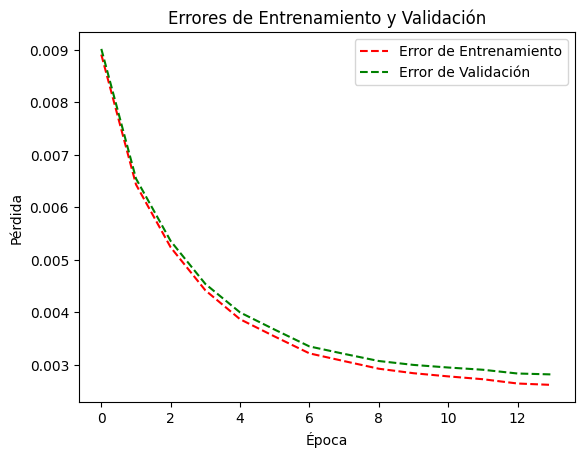

In [ ]:
# 5. Gráfico de errores de entrenamiento y validación
plt.plot(train_losses, label='Error de Entrenamiento', color='red', linestyle='--')
plt.plot(test_losses, label='Error de Validación', color='green', linestyle='--')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Errores de Entrenamiento y Validación')
plt.legend()
plt.show()

In [ ]:
# 6. Decisión sobre el número de épocas
def determinar_numero_epocas_error(error_set, patience=10, min_delta=0.00001):
    best_error = error_set[0]
    epochs_without_improvement = 0
    for i, error in enumerate(error_set):
        if error < best_error - min_delta:
            best_error = error
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                return i - patience
    return len(error_set)  # Si no converge en el conjunto, se devuelve el número total de épocas

z, w, y = [determinar_numero_epocas_error(train_losses_incorrecto), determinar_numero_epocas_error(test_losses), determinar_numero_epocas_error(train_losses)]
print(f"Época según error durante el entrenamiento: {z}")
print(f"Época según error de validación: {w}")
print(f"Época según error de entrenamiento: {y}")


Época según error durante el entrenamiento: 14
Época según error de validación: 14
Época según error de entrenamiento: 14


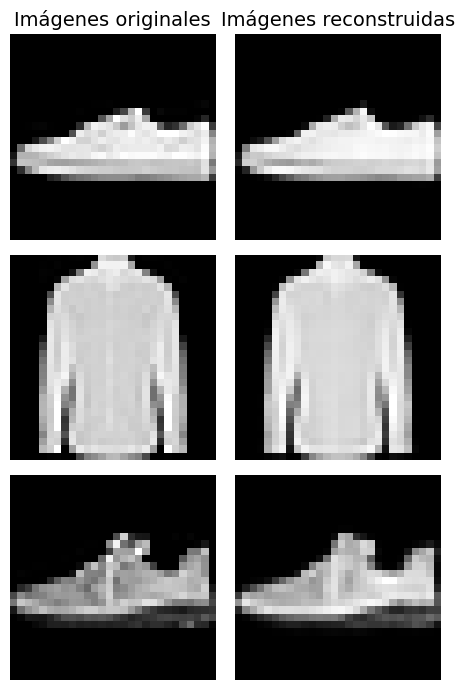

In [ ]:
# 7. Imágenes origninales vs predichas

# Crear semilla para obtener un índice aleatorio y reproducible
seed = 6
torch.manual_seed(seed)
random.seed(seed)

# Obtener la lista de índices del conjunto de validación
indices_val = list(range(len(valid_dataset)))

# Seleccionar tres índices de muestra aleatorios y fijarlos
sample_idx1, sample_idx2, sample_idx3 = random.sample(indices_val, 3)

# Obtener las nuevas imágenes y sus etiquetas del conjunto de validación
imagen1, label1 = valid_dataset[sample_idx1]
imagen2, label2 = valid_dataset[sample_idx2]
imagen3, label3 = valid_dataset[sample_idx3]

# Obtener las predicciones del modelo
with torch.no_grad():
    # Imagen 1
    imagen1_gpu = imagen1.to(device)
    imagen1_flatten = imagen1_gpu.unsqueeze(0).to(device)
    pred1_gpu = autoencoder(imagen1_flatten)
    pred1_cpu = pred1_gpu.cpu().view(1, 28, 28).squeeze().numpy()

    # Imagen 2
    imagen2_gpu = imagen2.to(device)
    imagen2_flatten = imagen2_gpu.unsqueeze(0).to(device)
    pred2_gpu = autoencoder(imagen2_flatten)
    pred2_cpu = pred2_gpu.cpu().view(1, 28, 28).squeeze().numpy()

    # Imagen 3
    imagen3_gpu = imagen3.to(device)
    imagen3_flatten = imagen3_gpu.unsqueeze(0).to(device)
    pred3_gpu = autoencoder(imagen3_flatten)
    pred3_cpu = pred3_gpu.cpu().view(1, 28, 28).squeeze().numpy()

# Crear una nueva figura con 3 filas y 2 columnas
fig, axes = plt.subplots(3, 2)
fig.set_size_inches(5, 7)

# Títulos de las filas
axes[0, 0].set_title('Imágenes originales', fontsize=14)
axes[0, 1].set_title('Imágenes reconstruidas', fontsize=14)

# Imagen original 1
axes[0, 0].imshow(imagen1.squeeze(), cmap="gray")
axes[0, 0].axis("off")

# Reconstrucción del autoencoder 1
axes[0, 1].imshow(pred1_cpu, cmap="gray")
axes[0, 1].axis("off")

# Imagen original 2
axes[1, 0].imshow(imagen2.squeeze(), cmap="gray")
axes[1, 0].axis("off")

# Reconstrucción del autoencoder 2
axes[1, 1].imshow(pred2_cpu, cmap="gray")
axes[1, 1].axis("off")

# Imagen original 3
axes[2, 0].imshow(imagen3.squeeze(), cmap="gray")
axes[2, 0].axis("off")

# Reconstrucción del autoencoder 3
axes[2, 1].imshow(pred3_cpu, cmap="gray")
axes[2, 1].axis("off")

# Ajustar el espacio horizontal entre las columnas
plt.subplots_adjust(wspace=0.01)

# Ajuste del diseño y mostrar la figura
fig.tight_layout()
plt.show()
